# Lab 2, Nearest Neighbour (NN)
by Domrachev Ivan, B20-RO-01

In [12]:
import torch
import torch.nn as nn
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from tqdm.notebook import tqdm 

from collections.abc import Iterable, Callable

## Part 1. Finishing lab task

Here, the task is to continue considering a toy example from the lab and test the second test data and consider another metric.

In [13]:
# Generating train data
train_data = np.array([
    np.eye(4) + np.eye(4)[::-1],
    np.ones((4,4))
])
train_data[1, 1:3, 1:3] = 0
print(train_data[0])
print(train_data[1])

train_labels = np.array([0, 1])

[[1. 0. 0. 1.]
 [0. 1. 1. 0.]
 [0. 1. 1. 0.]
 [1. 0. 0. 1.]]
[[1. 1. 1. 1.]
 [1. 0. 0. 1.]
 [1. 0. 0. 1.]
 [1. 1. 1. 1.]]


In [14]:
# Generating test data
test_data = np.copy(train_data)
test_data[0, ((1,2)), ((2,1)),] = 0
test_data[1, ((1, 3)), ((3, 2)),] = 0
test_data

array([[[1., 0., 0., 1.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [1., 0., 0., 1.]],

       [[1., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 1.],
        [1., 1., 0., 1.]]])

In [15]:
def KNN(
        train_ds: Iterable[np.array, np.array], 
        test_data: np.array, 
        dist_func: Callable[[np.array, np.array], np.array],
        K: int = 1
) -> int:
    """Predicts class of test_data given train_data
    
        Keyword arguments:
        train_ds -- (train_data, train_labels), the actual dataset
        test_data -- the data to be tested
        dist_func -- function to measure the distance
        
        Returns:
        Class prediction, according to the train_labels"""
    train_data, train_labels = train_ds
    distance = dist_func(train_data, test_data)
    if K == 1:
        return train_labels[distance.argmin()]
    else:
        # Get K indices of K least elements
        closest_classes = train_labels[np.argpartition(-distance, K)[:K]]
        # Return the most frequent inxed. If there are several,
        # return the first one (a.k.a. the smallest)
        return train_labels[
            closest_classes[closest_classes.argmax()]
        ]

In [16]:
def abs_dist(train_data: np.array, test_data: np.array) -> np.array:
    """ Measures distance as absolute distance between entries 
        
        Keyword arguments:
        train_data -- the actual dataset
        test_data -- the data to be tested
            
        Returns:
        Absolute distance for each train_data entry"""
    return np.abs(
        train_data - test_data
    ).sum(
        axis = tuple(
            i for i in range(1, train_data.ndim)
        )
    )


def mult_dist(train_data: np.array, test_data: np.array) -> np.array:
    """ Measures distance as matrix multiplication 
        
        Keyword arguments:
        train_data -- the actual dataset
        test_data -- the data to be tested
            
        Returns:
        Multiplication distance for each train_data entry"""
    # Apparently, one single multiplication is longer to compute
    # than many small ones (this becomes important for CIFAR10)
    sum = 0
    for train_entry in train_data:
        sum += (train_entry.T @ test_data.T).sum()
    
    return sum

In [17]:
# Making predictions for the data
pred1 = [
    KNN(
        (train_data, train_labels), 
        test_data_i, 
        abs_dist
    ) for test_data_i in test_data
]
pred2 = [
    KNN(
        (train_data, train_labels), 
        test_data_i, 
        mult_dist
    ) for test_data_i in test_data
]

pred1_labeled = ["cross" if pred1_i else "circle" for pred1_i in pred1]
pred2_labeled = ["cross" if pred2_i else "circle" for pred2_i in pred2]

pred1_labeled, pred2_labeled

(['circle', 'cross'], ['circle', 'circle'])

Overall, one could say that absolute distance metric (`abs_dist`) works better for this task, because it shows better performance for the second test entry. It is correct for the first metric, but incorrect for the second

## Part 2. Testing 2 KNN implementation

### 2.1. Implementing 2-KNN manually

First, one need to load CIFAR10 dataset:

In [25]:
transform = transforms.Compose([
    transforms.ToTensor(),
    # This normalization values are precomputed for CIFAR-10 dataset,
    # refer to: https://github.com/kuangliu/pytorch-cifar/issues/19
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2471, 0.2435, 0.2616)),
])

# Train
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          shuffle=False, num_workers=2)

# Test 
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset,
                                         shuffle=False, num_workers=2)

# List of classes
classes = trainset.classes

Files already downloaded and verified
Files already downloaded and verified


Let's convert the trainset and testset to the numpy arrays and test it's performance with our CNN implementation

In [26]:
train_data_np = trainset.data
train_labels_np = np.array(trainset.targets)
test_data_np = testset.data
test_labels_np = np.array(testset.targets)

In [ ]:
# ~16 seconds
N_pred1 = 1000
pred1 = np.zeros(N_pred1)
test_loop_1 = tqdm(
    enumerate(test_data_np[:N_pred1], 0), total=N_pred1, desc="Test absolute value"
)

for i, input in test_loop_1:
    pred1[i] = KNN (
        (train_data_np, train_labels_np), 
        input, 
        abs_dist
    )
    

In [11]:
# ~7.5 minutes
N_pred2 = 100
pred2 = np.zeros(N_pred2)
test_loop = tqdm(
    enumerate(test_data_np[:N_pred2], 0), total=N_pred2, desc="Test multiplication"
)

for i, input in test_loop:
    pred2[i]= KNN (
        (train_data_np, train_labels_np), 
        input, 
        mult_dist
    )
    

Test multiplication:   0%|          | 0/100 [00:00<?, ?it/s]

In [12]:
acc1 = (pred1 == test_labels_np[:N_pred1]).sum() / N_pred1
acc2 = (pred2 == test_labels_np[:N_pred2]).sum() / N_pred2

print(f"Accuracy of absolute distance: {acc1}")
print(f"Accuracy of product distance: {acc2}")

Accuracy of absolute distance: 0.253
Accuracy of product distance: 0.16


As one could see, the accuracy is quite low without encoding

### 2.2. Testing encoded data 

For a prepared encoder, I've decided to borrow a RESNET model, trained on CIFAR-10 from [here](https://github.com/huyvnphan/PyTorch_CIFAR10/tree/master).

In [13]:
# !git submodule add https://github.com/huyvnphan/PyTorch_CIFAR10.git

In [1]:
from mmpretrain import get_model
model = get_model('resnet18_8xb16_cifar10', pretrained=True)

# Option 2
# from PyTorch_CIFAR10.cifar10_models.resnet import resnet18

# model = resnet18()
# ckpt = torch.load("data/resnet18.pt")
# model.load_state_dict(ckpt)
# encoding_model = torch.nn.Sequential(*(list(model.children())[:-1]));
# encoding_model = model

# Option 3
# from torchvision.models import resnet18, ResNet18_Weights

# model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
# encoding_model = torch.nn.Sequential(*(list(model.children())[:-1]))

ImportError: cannot import name 'get_model' from 'mmpretrain' (unknown location)

Train encoding:   0%|          | 0/10 [00:00<?, ?it/s]

tensor([[-0.9271, -0.9681, -0.3975,  1.1962, -0.6604, -0.4932,  5.0223, -0.9464,
         -0.8999, -0.9259]])


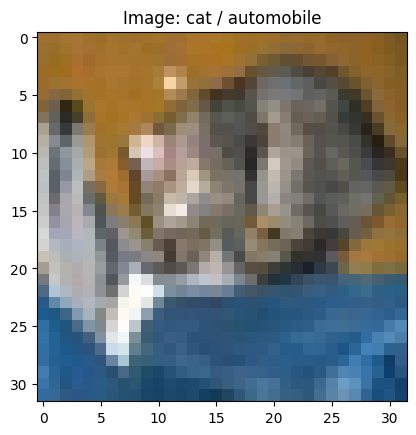

tensor([[-0.4893, -0.0946, -0.6898, -0.6269, -0.8623, -0.8320, -0.7928, -0.7388,
         -0.4906,  5.6170]])


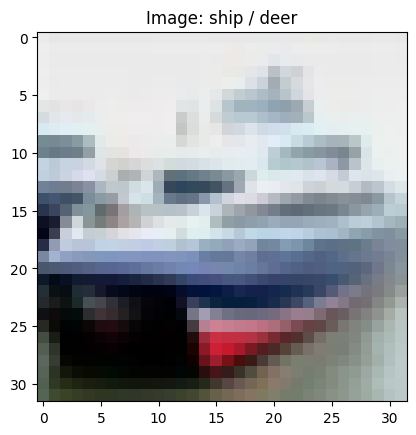

tensor([[-0.4968, -0.1258, -0.7098, -0.7505, -0.8941, -0.8851, -0.8656, -0.7751,
         -0.3828,  5.8856]])


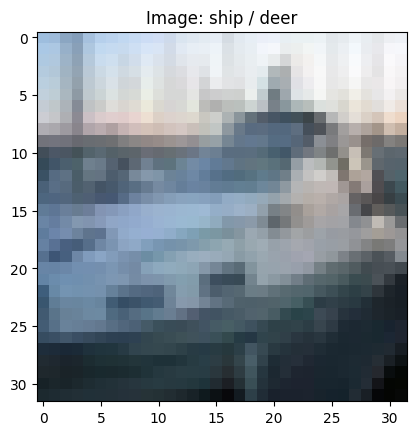

tensor([[-0.7896, -0.9863, -0.3834, -0.3752,  5.9436, -0.4674, -0.6705, -0.4047,
         -0.9219, -0.9444]])


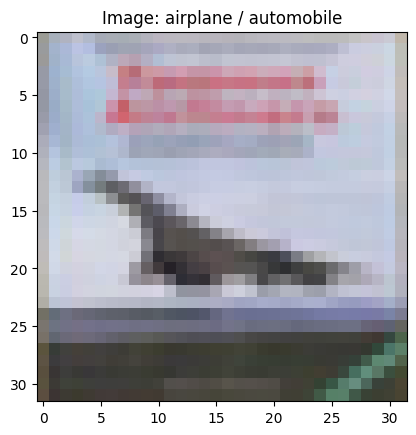

tensor([[-0.6229,  5.7444, -0.8185, -0.6949, -0.8686, -0.7290, -0.7289, -0.8359,
         -0.4775,  0.0318]])


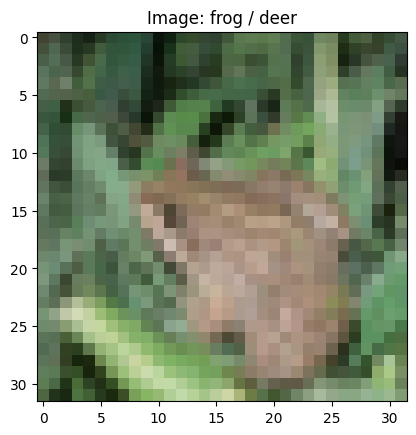

tensor([[-0.6320,  5.8183, -0.8057, -0.7527, -0.8690, -0.7693, -0.7412, -0.8315,
         -0.4673,  0.0504]])


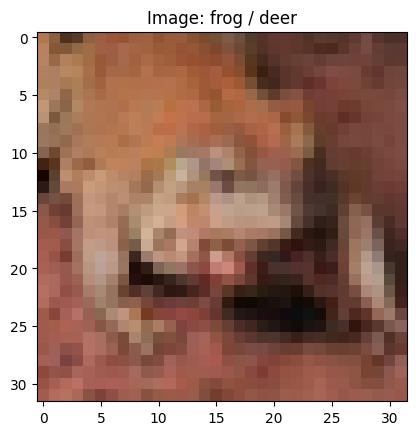

tensor([[-0.3568, -1.0267,  5.9747, -0.4529, -0.4471, -0.5947, -0.4721, -0.7588,
         -0.9491, -0.9165]])


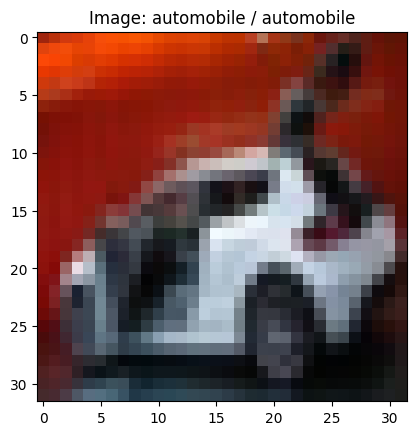

tensor([[-0.7164, -0.9173, -0.6365, -0.5731, -0.2507, -0.1783, -0.9141,  5.8935,
         -0.9200, -0.7873]])


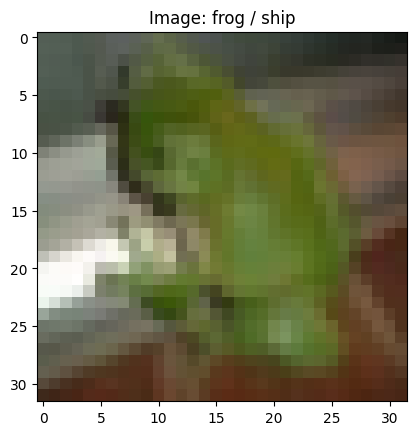

tensor([[-0.1969, -0.6014, -0.8254, -0.7285, -0.9209, -0.8906, -0.8673, -0.9205,
          6.4570, -0.5056]])


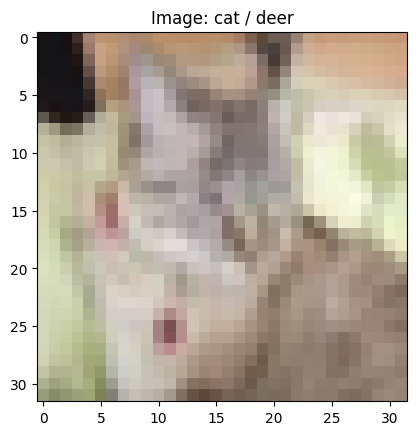

tensor([[-0.7223, -0.8891, -0.5869,  5.3199, -0.5923,  0.2292, -0.4815, -0.6292,
         -0.9415, -0.7062]])


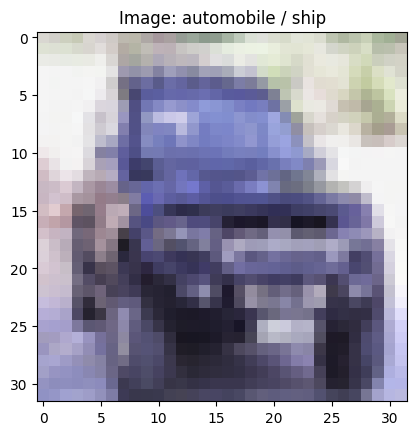

tensor([[-0.7394, -0.9310, -0.3706, -0.3000,  5.5221, -0.4387, -0.6015, -0.3865,
         -0.8639, -0.8905]])


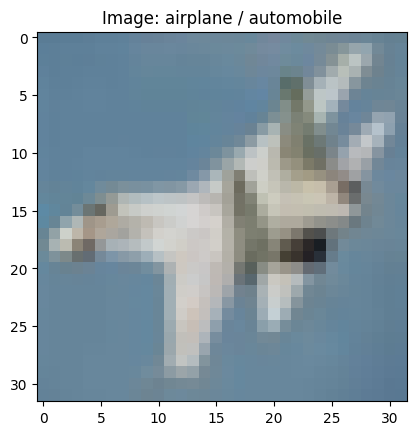

In [28]:
with torch.no_grad():
    encoding_model.eval()  # evaluation mode
    test_loop = tqdm(enumerate(trainloader, 0), total=10, desc="Train encoding")
            
    for i, input in test_loop:
        plt.imshow(test_data_np[i])
        preds = encoding_model(torch.autograd.Variable(input[0]))
        print(preds)
        pred_idx = np.argmin(preds)

        plt.title(f"Image: {classes[test_labels_np[i]]} / {classes[pred_idx]}")
        plt.show()
        if i > 9:
            break

In [7]:
trainset_encoded = []
with torch.no_grad():
    encoding_model.eval()  # evaluation mode
    test_loop = tqdm(enumerate(trainloader, 0), total=len(trainloader), desc="Train encoding")
    for i, inputs in test_loop:
        trainset_encoded.append(
            encoding_model(torch.autograd.Variable(inputs[0]))
        )

Train encoding:   0%|          | 0/50000 [00:00<?, ?it/s]

In [8]:
testset_encoded = []
with torch.no_grad():
    encoding_model.eval()  # evaluation mode
    test_loop = tqdm(enumerate(testloader, 0), total=len(testloader), desc="Test encoding")
    for i, inputs in test_loop:
        testset_encoded.append(
            encoding_model(torch.autograd.Variable(inputs[0]))
        )

Test encoding:   0%|          | 0/10000 [00:00<?, ?it/s]

In [9]:
trainset_encoded = np.array([entry.numpy() for entry in trainset_encoded]).reshape(50000, -1)
testset_encoded = np.array([entry.numpy() for entry in testset_encoded]).reshape(10000, -1)

trainset_encoded.shape, testset_encoded.shape

((50000, 512), (10000, 512))

Let's first try to test the encoded values with previous metric -- absolute distance:

Test encoded values, absolute distance:   0%|          | 0/1000 [00:00<?, ?it/s]

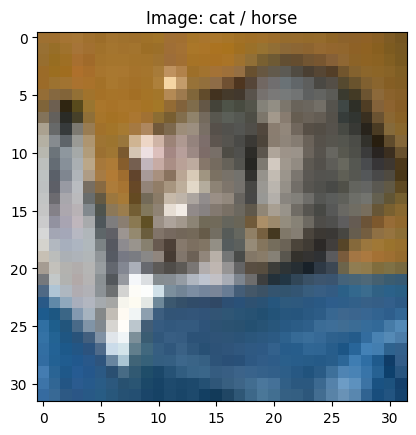

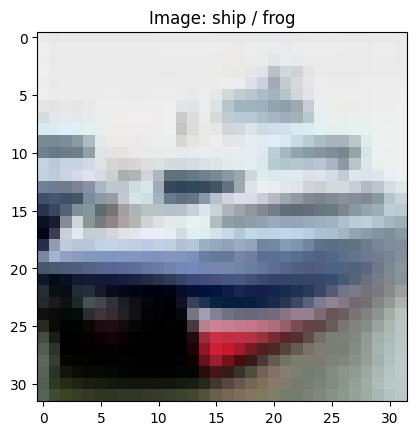

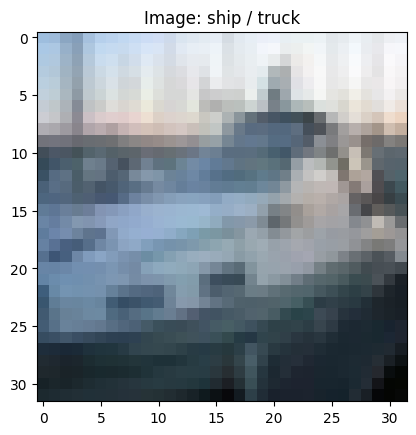

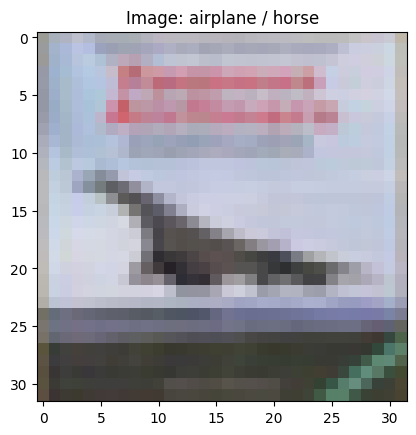

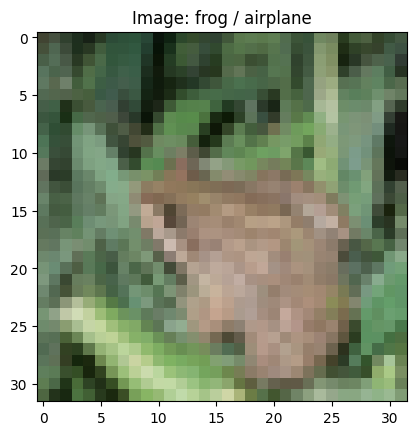

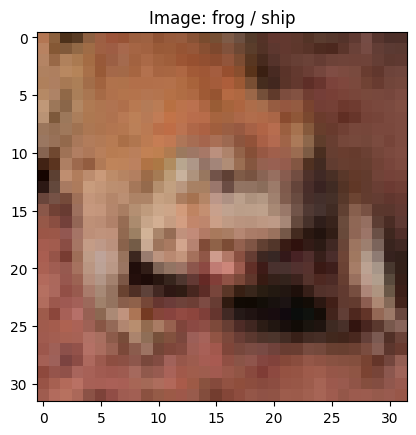

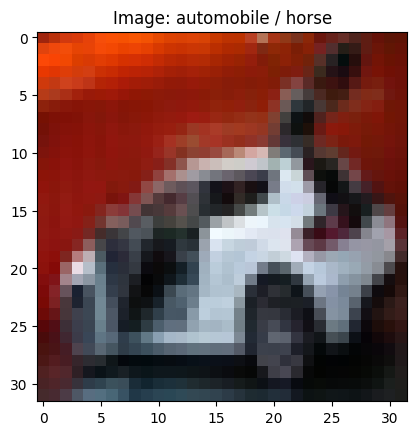

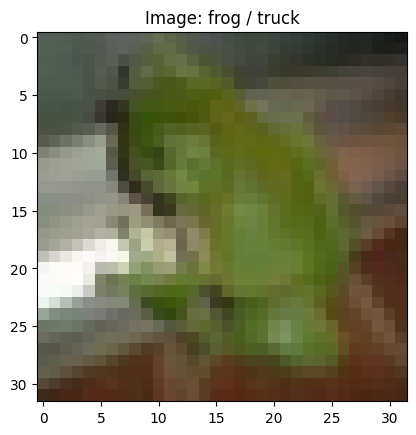

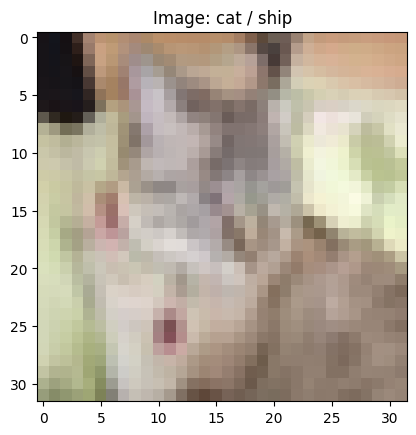

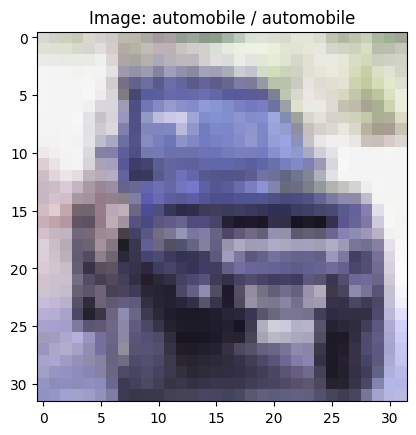

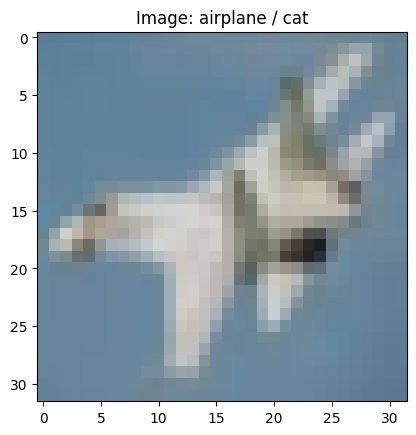

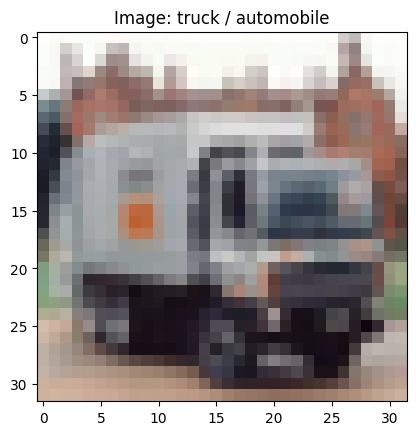

AssertionError: 

In [19]:
N_pred_encoded = 1000
pred_encoded = np.zeros(N_pred_encoded)
test_loop = tqdm(
    enumerate(testset_encoded[:N_pred_encoded], 0), total=N_pred_encoded, desc="Test encoded values, absolute distance"
)
for i, input in test_loop:
    pred_encoded[i] = KNN (
        (trainset_encoded, train_labels_np), 
        input, 
        abs_dist
    )
    

In [25]:
acc_encoded = (pred_encoded == test_labels_np[:N_pred_encoded]).sum() / N_pred_encoded
print(f"Accuracy of encoded values, absolute distance: {acc_encoded}")

Accuracy of encoded values, absolute distance: 0.101


In [26]:
def cosine_similarity(train_data: np.array, test_data: np.array) -> np.array:
    """ Measures cosine similarity between inputs
        
        Keyword arguments:
        train_data -- the actual dataset
        test_data -- the data to be tested
            
        Returns:
        Cosine similarity for each train_data entry"""
    
    return train_data.dot(test_data) / (
        np.linalg.norm(train_data) * np.linalg.norm(test_data)
    )

In [27]:
N_pred_encoded = 1000
pred_encoded = np.zeros(N_pred_encoded)
test_loop = tqdm(
    enumerate(testset_encoded[:N_pred_encoded], 0), total=N_pred_encoded, desc="Test encoded values, cosine similarity"
)
for i, input in test_loop:
    pred_encoded[i]= KNN (
        (trainset_encoded, train_labels_np), 
        input, 
        cosine_similarity
    )

Test encoded values, cosine similarity:   0%|          | 0/1000 [00:00<?, ?it/s]

In [28]:
acc_encoded = (pred_encoded == test_labels_np[:N_pred_encoded]).sum() / N_pred_encoded
print(f"Accuracy of encoded values, cosine similarity: {acc_encoded}")

Accuracy of encoded values, cosine similarity: 0.099


Results show that the cosine similarity metric show worse result, little more accurate than random prediction.

Here are the steps one might take to improve the accuracy of the result:
1. *Try another model*. I've considered two examples, but both of them failed to perform well. Hovewer, there exist some other options to test.
2. *Remove some convolutional layers*. The KNN algorithm generally works poorly for sparse data. Hence, one could try to remove more sensors from the initial NN and get more meaningful and dence feature list. *I failed to try this because it broke my OS*